In [4]:
%pip install gensim

  Using cached gensim-4.4.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 58.4 MB/s eta 0:00:00


In [5]:
import requests
import numpy as np
import bz2
import os
import shutil
import gensim # Для роботи з Word2Vec
from sklearn.decomposition import PCA # Для Завдання 6
import matplotlib.pyplot as plt
import sys
import re # Для очищення слів у візуалізації

#####**ЗАВДАННЯ 1:** Завантаження даних про аналогії

In [6]:
def load_analogy_data(url: str, section_name: str) -> list:
    """
    Завантажує та парсить файл з аналогіями (test_vocabulary.txt).
    Повертає лише ту секцію, яка нам потрібна (за варіантом).

    Примітка: Надана у конспекті функція pd.read_csv не підходить
    для формату цього файлу. Використовуємо ручний парсинг.
    """
    print(f"Завантаження файлу аналогій з {url}...")
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"ПОМИЛКА: Не вдалося завантажити файл аналогій: {e}")
        return []

    analogies = []
    in_section = False
    section_name_lower = section_name.lower().strip()

    lines = response.text.splitlines()

    for line in lines:
        line = line.strip()

        # Якщо ми знайшли початок нової секції
        if line.startswith(':'):
            current_section = line.lower().strip()
            # Перевіряємо, чи це наша секція
            if current_section == section_name_lower:
                print(f"Знайдено секцію '{section_name}'. Починаю парсинг...")
                in_section = True
            else:
                in_section = False # Це інша секція

        # Якщо ми в потрібній секції, додаємо слова
        elif in_section:
            words = line.split()
            if len(words) == 4:
                # Зберігаємо у форматі (A, B, C, D)
                # де A:B :: C:D (A до B як C до D)
                analogies.append(tuple(words))

    print(f"Парсинг завершено. Завантажено {len(analogies)} прикладів аналогій.")
    return analogies

#####**ЗАВДАННЯ 2:** Завантаження векторних представлень (Word2Vec)

In [7]:
def load_word2vec_model(url: str) -> gensim.models.KeyedVectors:
    """
    Завантажує, розпаковує та завантажує в пам'ять модель Word2Vec.
    !!! ЦЯ ФУНКЦІЯ ВИМАГАЄ БАГАТО ЧАСУ, RAM ТА МІСЦЯ НА ДИСКУ !!!
    """
    bz2_filename = 'ubercorpus.cased.tokenized.word2vec.300d.bz2'
    uncompressed_filename = 'ubercorpus.cased.tokenized.word2vec.300d.vec' # Змінено .vec

    # --- 1. Завантаження (якщо файлу ще немає) ---
    if not os.path.exists(bz2_filename):
        print(f"Завантаження моделі з {url} (530MB)...")
        print("Це може зайняти 10-20 хвилин залежно від вашого інтернету.")
        try:
            with requests.get(url, stream=True) as r:
                r.raise_for_status()
                with open(bz2_filename, 'wb') as f:
                    shutil.copyfileobj(r.raw, f)
            print("Завантаження завершено.")
        except Exception as e:
            print(f"ПОМИЛКА завантаження моделі: {e}")
            return None
    else:
        print(f"Файл моделі {bz2_filename} вже існує. Пропускаю завантаження.")

    # --- 2. Розпакування (якщо файл ще не розпаковано) ---
    if not os.path.exists(uncompressed_filename):
        print(f"Розпакування {bz2_filename} ( >1.5GB )...")
        print("Це може зайняти 5-15 хвилин.")
        try:
            with bz2.BZ2File(bz2_filename, 'rb') as f_in:
                with open(uncompressed_filename, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out) # Потокове розпакування
            print("Розпакування завершено.")
        except Exception as e:
            print(f"ПОМИЛКА розпакування: {e}")
            return None
    else:
        print(f"Розпакований файл {uncompressed_filename} вже існує. Пропускаю.")

    # --- 3. Завантаження в Gensim ---
    print("Завантаження моделі в пам'ять (Gensim)...")
    print("Це може зайняти 1-5 хвилин та вимагає >2GB RAM.")
    try:
        # 'binary=False', оскільки модель ubercorpus - це текстовий .vec файл
        model = gensim.models.KeyedVectors.load_word2vec_format(
            uncompressed_filename,
            binary=False
        )
        print("Модель успішно завантажено в пам'ять.")
        return model

    except Exception as e:
        print(f"ПОМИЛКА завантаження моделі в Gensim: {e}")
        return None

#####**ЗАВДАННЯ 3:** Функції косинусної подібності та евклідової відстані

In [8]:
def cosine_similarity(u, v):
    """Обчислює косинусну подібність (з опису)"""
    return np.dot(u,v) / (np.linalg.norm(u) * np.linalg.norm(v))

def euclidean_distance(u, v):
    """Обчислює евклідову відстань (з опису)"""
    return np.linalg.norm(u - v)

#####**ЗАВДАННЯ 4:** Функція пошуку аналогій

In [9]:
def find_analogy(w1: str, w2: str, w3: str, model: gensim.models.KeyedVectors):
    """
    Знаходить слово w4 за аналогією A:B :: C:D (w1:w2 :: w3:w4)
    Що означає: w4 ≈ w2 - w1 + w3

    Примітка: Функції 'find_analogy' та 'get_country' з опису були
    або логічно некоректними для цієї задачі, або вкрай неефективними.
    Ця функція реалізує правильну логіку (B - A + C)
    використовуючи оптимізований метод gensim.
    """
    try:
        # Перевіряємо, чи всі слова є в моделі
        if w1 not in model or w2 not in model or w3 not in model:
            return None

        # Використовуємо вбудований метод: w4 = w2 - w1 + w3
        # positive=[w2, w3], negative=[w1]
        result = model.most_similar(positive=[w2, w3], negative=[w1], topn=1)

        return result[0][0] # Повертаємо слово (перший елемент першого кортежу)

    except Exception as e:
        print(f"Помилка під час пошуку аналогії: {e}")
        return None

#####**ЗАВДАННЯ 5:** Тестування точності (Accuracy)

In [10]:
def test_model_accuracy(model: gensim.models.KeyedVectors, analogy_data: list):
    """
    Проходить по всіх аналогіях і обчислює точність (accuracy).

    Примітка: Функція 'get_accuracy' з опису була неефективною
    та логічно прив'язаною до іншого варіанту. Ця функція
    використовує наш список аналогій.
    """
    correct = 0
    total_valid_tests = 0 # Загальна кількість тестів, де всі слова є в моделі

    # (w1, w2, w3, expected_w4)
    for w1, w2, w3, expected_w4 in analogy_data:

        # Перевіряємо, чи всі 4 слова є в моделі, інакше тест неможливий
        if w1 not in model or w2 not in model or w3 not in model or expected_w4 not in model:
            continue

        total_valid_tests += 1
        predicted_w4 = find_analogy(w1, w2, w3, model)

        # Порівнюємо без урахування регістру
        if predicted_w4 and (predicted_w4.lower() == expected_w4.lower()):
            correct += 1

    if total_valid_tests == 0:
        print("ПОМИЛКА: Жодна з аналогій не містить слів, присутніх у моделі.")
        return 0.0

    accuracy = correct / total_valid_tests
    return accuracy

#####**ЗАВДАННЯ 6:** Візуалізація векторів (PCA)

In [11]:
def visualize(words, model, filename="pca_visualization.png"):
    """
    Візуалізує список слів за допомогою PCA.
    (Адаптовано з опису, виправлено помилки)
    """

    # Очищуємо та фільтруємо слова, які є в моделі
    valid_words = []
    for w in words:
        # Модель cased, пробуємо різні варіанти
        if w in model:
            valid_words.append(w)
        elif w.capitalize() in model:
             valid_words.append(w.capitalize())
        elif w.lower() in model:
             valid_words.append(w.lower())

    if len(valid_words) < 2:
        print("ПОМИЛКА: Недостатньо слів для PCA (потрібно щонайменше 2).")
        return

    print(f"Візуалізація {len(valid_words)} слів, знайдених у моделі...")

    # Створюємо вектори слів
    word_vectors = np.array([model[w] for w in valid_words])

    pca = PCA(n_components=2)
    components = pca.fit_transform(word_vectors)

    plt.figure(figsize=(12, 10))
    plt.scatter(components[:, 0], components[:, 1], edgecolors='k', c='c', s=100)

    for i, word in enumerate(valid_words):
        # Очищуємо слово від службових символів (для української)
        display_word = re.sub(r'_.+$', '', word) # Видаляємо теги (напр., _NOUN)
        plt.annotate(display_word, xy=(components[i, 0], components[i, 1]), fontsize=12)

    plt.title("Візуалізація векторів слів (PCA, 2D)")
    plt.xlabel("Головна компонента 1")
    plt.ylabel("Головна компонента 2")
    plt.grid(True)

    # Збереження файлу
    plt.savefig(filename)
    print(f"\nГрафік PCA збережено у файл '{filename}'")
    plt.show() # Графік інтерактивно

####ГОЛОВНА ФУНКЦІЯ (ЗАПУСК)

--- Лабораторна робота № 3: Початок ---
Варіант: : adjective-adverb
Завантаження файлу аналогій з https://raw.githubusercontent.com/lang-uk/vecs/refs/heads/master/test/test_vocabulary.txt...
Знайдено секцію ': adjective-adverb'. Починаю парсинг...
Парсинг завершено. Завантажено 961 прикладів аналогій.
Завантаження моделі з https://lang.org.ua/static/downloads/models/ubercorpus.cased.tokenized.word2vec.300d.bz2 (530MB)...
Це може зайняти 10-20 хвилин залежно від вашого інтернету.
Завантаження завершено.
Розпакування ubercorpus.cased.tokenized.word2vec.300d.bz2 ( >1.5GB )...
Це може зайняти 5-15 хвилин.
Розпакування завершено.
Завантаження моделі в пам'ять (Gensim)...
Це може зайняти 1-5 хвилин та вимагає >2GB RAM.
Модель успішно завантажено в пам'ять.

--- Завдання 3 (Демонстрація) ---
Косинусна подібність(добрий, добре): 0.3947
Косинусна подібність(добрий, поганий): 0.7381
Евклідова відстань(добрий, добре): 22.7884

--- Завдання 4 (Демонстрація) ---
Аналогія: дивно - дивний + очевидний

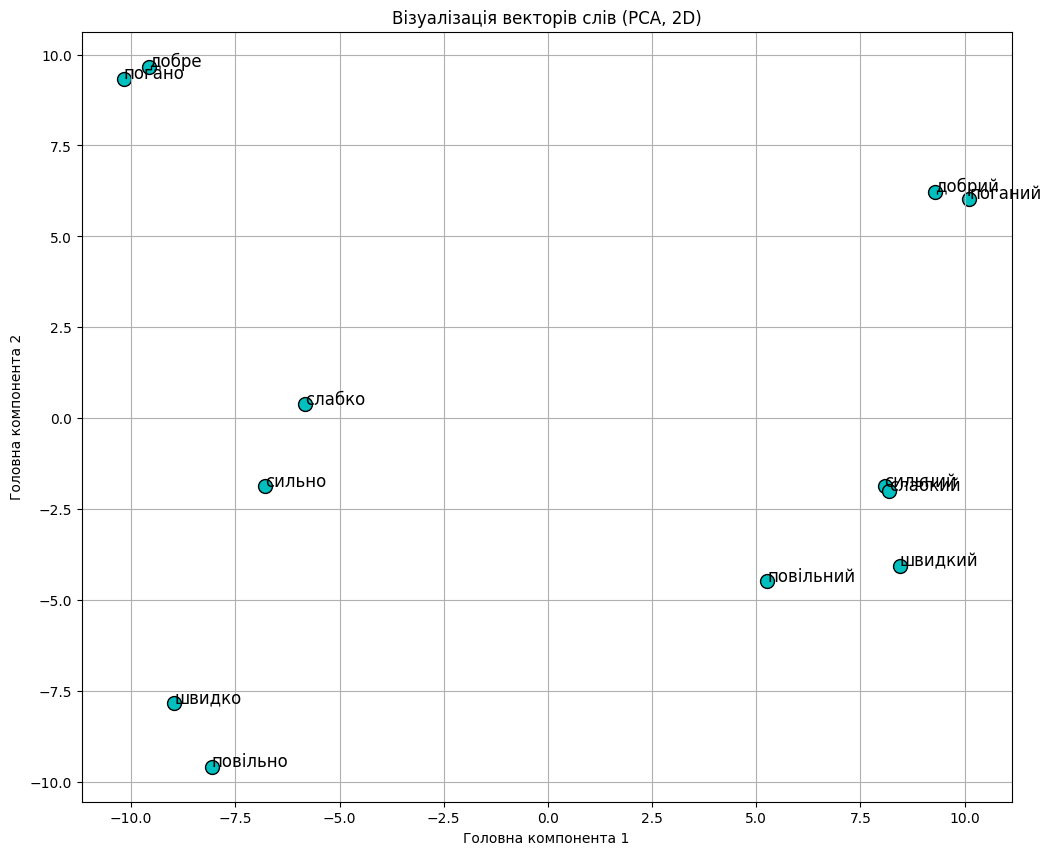

In [12]:
if __name__ == "__main__":

    # --- Параметри (змінено згідно варіанту 6) ---
    ANALOGY_URL = "https://raw.githubusercontent.com/lang-uk/vecs/refs/heads/master/test/test_vocabulary.txt"
    ANALOGY_SECTION = ": adjective-adverb" # <-- ВАРІАНТ 6

    MODEL_URL = "https://lang.org.ua/static/downloads/models/ubercorpus.cased.tokenized.word2vec.300d.bz2"


    print("--- Лабораторна робота № 3: Початок ---")
    print(f"Варіант: {ANALOGY_SECTION}")

    # --- Завдання 1 ---
    analogy_data = load_analogy_data(ANALOGY_URL, ANALOGY_SECTION)

    if not analogy_data:
        print("Роботу зупинено, оскільки не вдалося завантажити дані для аналогій.")
        sys.exit(1)

    # --- Завдання 2 ---
    # !!! УВАГА: Наступна функція вимагає багато часу, RAM та місця на диску
    model = load_word2vec_model(MODEL_URL)

    if model is None:
        print("Роботу зупинено, оскільки не вдалося завантажити модель Word2Vec.")
        sys.exit(1)

    # --- Завдання 3 (Демонстрація) ---
    print("\n--- Завдання 3 (Демонстрація) ---")
    try:
        # Слова з вашого варіанту
        v_good = model['добрий']
        v_well = model['добре']
        v_bad = model['поганий']

        print(f"Косинусна подібність(добрий, добре): {cosine_similarity(v_good, v_well):.4f}")
        print(f"Косинусна подібність(добрий, поганий): {cosine_similarity(v_good, v_bad):.4f}")
        print(f"Евклідова відстань(добрий, добре): {euclidean_distance(v_good, v_well):.4f}")
    except KeyError as e:
        print(f"Помилка демо: слово {e} відсутнє в моделі.")

    # --- Завдання 4 (Демонстрація) ---
    print("\n--- Завдання 4 (Демонстрація) ---")
    # Беремо перший приклад з нашого списку ': adjective-adverb'
    if analogy_data:
        # Напр: ('дивовижний', 'дивовижно', 'очевидний', 'очевидно')
        w1, w2, w3, exp_w4 = analogy_data[0]
        pred_w4 = find_analogy(w1, w2, w3, model)
        # Аналогія: w2 - w1 + w3 = w4
        print(f"Аналогія: {w2} - {w1} + {w3} = ?")
        print(f"  Очікувано: {exp_w4}")
        print(f"  Знайдено моделлю: {pred_w4}")

    # --- Завдання 5 (Розрахунок) ---
    print("\n--- Завдання 5 (Розрахунок) ---")
    print(f"Обчислення точності на всіх аналогіях секції '{ANALOGY_SECTION}'...")
    accuracy = test_model_accuracy(model, analogy_data)
    print(f"Точність (Accuracy) моделі на аналогіях: {accuracy * 100:.2f}%")

    # --- Завдання 6 (Візуалізація) ---
    print("\n--- Завдання 6 (Візуалізація) ---")
    # Список слів для візуалізації
    words_to_visualize = [
        'добрий', 'добре',
        'поганий', 'погано',
        'швидкий', 'швидко',
        'повільний', 'повільно',
        'сильний', 'сильно',
        'слабкий', 'слабко'
    ]
    visualize(words_to_visualize, model)